In [3]:
#Install Packages for sentiment analysis

import os
import pandas as pd
from dotenv import load_dotenv
import nltk as nltk
import requests
from pathlib import Path
import datetime as dt
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
from newsapi import NewsApiClient
%matplotlib inline

[nltk_data] Downloading package vader_lexicon to C:\Users\Aaron
[nltk_data]     Simpson\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [4]:
# Load dot env and News API key

load_dotenv()
api_key = os.getenv("NEWS_API_KEY")

In [5]:
# Create the newsapi client

newsapi = NewsApiClient(api_key=api_key)

In [6]:
apple_news = newsapi.get_everything(
    q="Apple AND 2020 AND 2021 AND 2022",
    language="en"
)

microsoft_news = newsapi.get_everything(
    q="Microsoft AND 2020 AND 2021 AND 2022",
    language="en"
)

google_news = newsapi.get_everything(
    q="Google AND 2020 AND 2021 AND 2022",
    language="en"
)

amazon_news = newsapi.get_everything(
    q="Amazon AND 2020 AND 2021 AND 2022",
    language="en"
)

tesla_news = newsapi.get_everything(
    q="Tesla AND 2020 AND 2021 AND 2022",
    language="en"
)

berkshire_news = newsapi.get_everything(
    q="Berkshire AND 2020 AND 2021 AND 2022",
    language="en"
)

meta_news = newsapi.get_everything(
    q="Meta AND 2020 AND 2021 AND 2022",
    language="en"
)

johnson_and_johnson_news = newsapi.get_everything(
    q="Johnson & Johnson AND 2020 AND 2021 AND 2022",
    language="en"
)

tesla_news = newsapi.get_everything(
    q="Tesla AND 2020 AND 2021 AND 2022",
    language="en"
)

unitedhealth_news = newsapi.get_everything(
    q="United Health AND 2020 AND 2021 AND 2022",
    language="en"
)

nvidia_news = newsapi.get_everything(
    q="NVIDIA AND 2020 AND 2021 AND 2022",
    language="en"
)

# Show the total number of news
apple_news["totalResults"]
microsoft_news["totalResults"]
google_news["totalResults"]
amazon_news["totalResults"]
tesla_news["totalResults"]
berkshire_news["totalResults"]
meta_news["totalResults"]
johnson_and_johnson_news["totalResults"]
unitedhealth_news["totalResults"]
nvidia_news["totalResults"]

228

In [28]:
#Create function to display articles in data

def create_df(news, language):
    articles = []
    for article in news:
        try:
            title = article["title"]
            description = article["description"]
            text = article["content"]
            date = article["publishedAt"][:10]
            
            articles.append({
                "title": title,
                "description": description,
                "text": text,
                "date": date,
                "language": language
            })
        except AttributeError as ae:
            pass

    return pd.DataFrame(articles)

In [29]:
# Create a DataFrame with the news articles

apple_news_df = create_df(apple_news["articles"], "en")
apple_news_df['Ticker']='AAPL'
microsoft_news_df = create_df(microsoft_news["articles"], "en")
microsoft_news_df['Ticker']='MSFT'
google_news_df = create_df(google_news["articles"], "en")
google_news_df['Ticker']='GOOGL'
amazon_news_df = create_df(amazon_news["articles"], "en")
amazon_news_df['Ticker']='AMZN'
tesla_news_df = create_df(tesla_news["articles"], "en")
tesla_news_df['Ticker']='TSLA'
berkshire_news_df = create_df(berkshire_news["articles"], "en")
berkshire_news_df['Ticker']='BRK.A'
meta_news_df = create_df(meta_news["articles"], "en")
meta_news_df['Ticker']='FB'
johnson_news_df = create_df(johnson_and_johnson_news["articles"], "en")
johnson_news_df['Ticker']='JNJ'
unitedhealth_news_df = create_df(unitedhealth_news["articles"], "en")
unitedhealth_news_df['Ticker']='UNH'
nvidia_news_df = create_df(nvidia_news["articles"], "en")
nvidia_news_df['Ticker']='NVDA'

In [30]:
#Display Articles
apple_news_df.head()

,title,description,text,date,language,Ticker
0,Apple can't dodge rival app store Cydia's anti...,Apple Inc on Thursday lost a bid to dismiss <a...,<ul><li>\r\nSummary</li><li>\r\nLaw firms</li>...,2022-05-27,en,AAPL
1,How to Watch Apple's WWDC 2022 Keynote on June 6,The 2022 Worldwide Developers Conference is se...,The 2022 Worldwide Developers Conference is se...,2022-06-02,en,AAPL
2,Apple Fails in Bid to Dismiss Amended Cydia Cr...,Apple has lost a bid to dismiss an antitrust l...,Apple has lost a bid to dismiss an antitrust l...,2022-05-30,en,AAPL
3,Apple's AR/VR Headset Nearing Completion as Bo...,Apple last week demonstrated its upcoming AR/V...,Apple last week demonstrated its upcoming AR/V...,2022-05-19,en,AAPL
4,"What to Expect at WWDC 2022: iOS 16, macOS 13,...",Apple's 33rd annual Worldwide Developers Confe...,Apple's 33rd annual Worldwide Developers Confe...,2022-06-03,en,AAPL


In [31]:
microsoft_news_df.head()

,title,description,text,date,language,Ticker
0,Microsoft’s Xbox streaming stick and TV app ar...,Microsoft is working on a Roku-esque Xbox stre...,I dont think anything is going to stop us from...,2022-05-06,en,MSFT
1,U.S. House speaker Pelosi discloses trades in ...,U.S. House Speaker Nancy Pelosi disclosed new ...,June 6 (Reuters) - U.S. House Speaker Nancy Pe...,2022-06-06,en,MSFT
2,Microsoft announces new ‘family’ of identity a...,Microsoft announces the launch of Microsoft En...,We are excited to bring Transform 2022 back in...,2022-05-31,en,MSFT
3,2022’s Xbox and Bethesda Showcase is vital for...,Microsoft needs to show why we should care abo...,"On June 12, Microsoft will hold its second ann...",2022-06-05,en,MSFT
4,Wayve and Microsoft partner to scale autonomou...,Wayve announced a partnership with Microsoft t...,We are excited to bring Transform 2022 back in...,2022-05-18,en,MSFT


In [32]:
google_news_df.head()

,title,description,text,date,language,Ticker
0,Google brings transcripts and auto-translated ...,Google is rolling out auto-translated video ca...,Google is rolling out auto-translated video ca...,2022-05-11,en,GOOGL
1,Lawyer David Boies bills $1950 hourly in Googl...,Prominent trial lawyer David Boies is billing ...,(Reuters) - Prominent trial lawyer David Boies...,2022-06-06,en,GOOGL
2,"Bruce Campbell's Top Picks: June 1, 2022 - BNN","<ol><li>Bruce Campbell's Top Picks: June 1, 20...","Bruce Campbell, president and portfolio manage...",2022-06-01,en,GOOGL
3,U.S. groups urge social media companies to fig...,Social media companies including Facebook <a h...,"WASHINGTON, May 12 (Reuters) - Social media co...",2022-05-12,en,GOOGL
4,Hollywood legend Kevin Costner named 2022 Calg...,<ol><li>Hollywood legend Kevin Costner named 2...,Article content\r\nEveryones favourite rancher...,2022-05-31,en,GOOGL


In [33]:
amazon_news_df.head()

,title,description,text,date,language,Ticker
0,"Oracle Java Popularity Sliding, Reports New Relic","InfoWorld reports that ""While still the indust...",The finding was included the company's 2022 St...,2022-05-09,en,AMZN
1,Biden has the perfect new enemy: Jeff Bezos,Bezos has gone from praising Biden's 2020 vict...,The most powerful man in the world and one of ...,2022-05-16,en,AMZN
2,FBA Aggregators: What Makes Amazon FBA Brands ...,Learn why Amazon FBA brands are highly desirab...,The market for acquiring Amazon FBA businesses...,2022-05-25,en,AMZN
3,The 2020 Roku Ultra now comes with the 2021 Vo...,Roku is finally selling its best streaming har...,Roku today announced that it’s now packaging t...,2022-05-12,en,AMZN
4,Hollywood legend Kevin Costner named 2022 Calg...,<ol><li>Hollywood legend Kevin Costner named 2...,Article content\r\nEveryones favourite rancher...,2022-05-31,en,AMZN


In [34]:
tesla_news_df.head()

,title,description,text,date,language,Ticker
0,Bitcoin plunges to lowest price since 2020 ami...,"The ""stablecoin"" Tether briefly lost its peg t...","23 with 16 posters participating, including st...",2022-05-12,en,TSLA
1,Tesla recalls U.S. 130000 vehicles over touchs...,"Tesla Inc <a href=""https://www.reuters.com/com...",The company and law firm names shown above are...,2022-05-10,en,TSLA
2,VW boss admits speed of Tesla’s expansion surp...,"In terms of electric car sales, Herbert Diess ...","Volkswagens chief executive, Herbert Diess, ha...",2022-05-09,en,TSLA
3,Column: Nickel demand boomed in 2021; this yea...,Global nickel usage surged by an extraordinary...,"LONDON, May 18 (Reuters) - Global nickel usage...",2022-05-18,en,TSLA
4,Ford throws shade at Tesla with a new ad celeb...,"I don’t own a TV (streaming all the way), but ...","I dont own a TV (streaming all the way), but I...",2022-05-06,en,TSLA


In [35]:
berkshire_news_df.head()

,title,description,text,date,language,Ticker
0,Warren Buffett's Best Stocks of 2022 So Far: A...,Two of the three are new positions for Berkshi...,Warren Buffett has certainly delivered stronge...,2022-05-19,en,BRK.A
1,"3 Warren Buffett Stocks With Up to 36% Upside,...",Wall Street analysts see upside in several Ber...,"With markets in correction territory, buying o...",2022-05-12,en,BRK.A
2,Warren Buffett and Berkshire Hathaway Are Inve...,"In the first quarter of 2022, Warren Buffett's...",In its recently released 13F regulatory filing...,2022-05-20,en,BRK.A
3,"If You'd Invested $1,000 in Snowflake in 2020,...",The hottest tech IPO of 2020 has nearly return...,Snowflake(SNOW -1.87%) went public on Sept. 16...,2022-05-24,en,BRK.A
4,"Down 30%, Is Now The Time to Buy This Baby-Ber...",This company has made some great investments b...,Markets have not been kind to investors so far...,2022-05-27,en,BRK.A


In [36]:
meta_news_df.head()

,title,description,text,date,language,Ticker
0,Study struggles to explain why Quebec has high...,MONTREAL — Researchers are having a hard time ...,MONTREAL Researchers are having a hard time ex...,2022-05-30,en,FB
1,Study struggles to explain why Quebec has high...,MONTREAL — Researchers are having a hard time ...,MONTREAL Researchers are having a hard time ex...,2022-05-30,en,FB
2,Study struggles to explain why Quebec has high...,MONTREAL — Researchers are having a hard time ...,MONTREAL Researchers are having a hard time ex...,2022-05-30,en,FB
3,Avalanche leak suggests cloud gaming could com...,Meta is allegedly developing a cloud gaming fe...,What you need to know\r\n<ul><li>A Redditor le...,2022-05-27,en,FB
4,Tony awards 2022: A Strange Loop leads the nom...,Three actors from The Lehman Trilogy go head t...,British talents have reaped a phenomenal array...,2022-05-09,en,FB


In [37]:
johnson_news_df.head()

,title,description,text,date,language,Ticker
0,"For two years, this Washington island has grap...","The virus hit Whidbey Island early in 2020, an...","Tony Johnson sits on his bed with his dog, Das...",2022-05-18,en,JNJ
1,Johnson-Thompson backs herself to recover for ...,<ul><li>She records her third worst points tot...,Moments after Katarina Johnson-Thompson crosse...,2022-05-29,en,JNJ
2,"Relief and Reunions After Shanghai Reopens, bu...","The authorities kept some restrictions, such a...",Despite strong levels of vaccination among old...,2022-06-01,en,JNJ
3,Was no gravestone left unturned to smear Keir?...,Even the dead didn’t escape Nadine Dorries’s c...,"Frank Dobson, the former Labour MP for Holborn...",2022-05-08,en,JNJ
4,Strong T-cell response for blood cancer patien...,The following is a summary of some recent stud...,June 6 (Reuters) - The following is a summary ...,2022-06-06,en,JNJ


In [38]:
unitedhealth_news_df.head()

,title,description,text,date,language,Ticker
0,"Factbox: How Canada, Australia, UK changed law...",A shooting at a Texas elementary school that k...,May 26 (Reuters) - A shooting at a Texas eleme...,2022-05-26,en,UNH
1,Explainer: Are guns illegal in Canada? Key que...,Canada's government introduced legislation on ...,May 31 (Reuters) - Canada's government introdu...,2022-05-31,en,UNH
2,"Travel boom spurs sales of suitcases, cigarett...",As more people resume travel and plan vacation...,May 19 (Reuters) - As more people resume trave...,2022-05-19,en,UNH
3,COVID-19 Live Updates: News on coronavirus in ...,<ol><li>COVID-19 Live Updates: News on coronav...,Watch this page throughout the day for updates...,2022-05-12,en,UNH
4,ICE fast-tracked the release of immigrants 'on...,"Per the Los Angeles Times, the 16,000 document...","Over the last few years, Immigration and Custo...",2022-05-14,en,UNH


In [39]:
nvidia_news_df.head()

,title,description,text,date,language,Ticker
0,"S&P 500 on pace to confirm bear market, falls ...","The benchmark S&P 500 index <a href=""https://w...",May 20 (Reuters) - The benchmark S&amp;P 500 i...,2022-05-20,en,NVDA
1,Sony's Bringing Even More PlayStation Games To...,Sony plans to expand significantly into PC gam...,Sony plans to expand significantly into PC gam...,2022-05-26,en,NVDA
2,2022’s Xbox and Bethesda Showcase is vital for...,Microsoft needs to show why we should care abo...,"On June 12, Microsoft will hold its second ann...",2022-06-05,en,NVDA
3,The decade of ignoring your gaming PC’s power ...,"For around a decade, there hasn't been a reaso...",I never think about the power supply in my gam...,2022-05-22,en,NVDA
4,"1 Green Flag for Nvidia in 2022, and 1 Red Flag",Nvidia's stock is down substantially in 2022 a...,2022 has been a challenging year for Nvidia(NV...,2022-06-02,en,NVDA


In [40]:
#Combine DataFrames for top 10abs

combined_market_news_df = pd.concat([apple_news_df, microsoft_news_df, google_news_df, amazon_news_df, tesla_news_df, berkshire_news_df, meta_news_df, johnson_news_df, unitedhealth_news_df, nvidia_news_df], ignore_index=True)
combined_market_news_df.tail()

,title,description,text,date,language,Ticker
195,Artificial Intelligence in Healthcare Market G...,Major players in the artificial intelligence i...,Major players in the artificial intelligence i...,2022-06-03,en,NVDA
196,"Sony shares sales numbers of PC ports, expects...",Sony's PC publishing division has been a very ...,Sony has seen impressive sales numbers in the ...,2022-05-26,en,NVDA
197,"Where Nvidia, AMD, Intel and Qualcomm Shares N...","Following their recent selloffs, two of these ...","Nvidia (NVDA) , Advanced Micro Devices (AMD) ...",2022-05-10,en,NVDA
198,3 Growth Stocks for the Next 10 Years and Beyond,These companies are on track to win big from l...,"So far, 2022 his hasn't been a good year for g...",2022-05-13,en,NVDA
199,Li Auto Inc. (LI) Q1 2022 Earnings Call Transc...,LI earnings call for the period ending March 3...,Image source: The Motley Fool.\r\nLi Auto Inc....,2022-05-10,en,NVDA


In [41]:
# Save to CSV
file_path = Path("/Resources/")
combined_market_news_df.to_csv("market_news_2.csv", index=False, encoding='utf-8-sig')

In [42]:
# Sentiment calculation based on compound score
def get_sentiment(score):
    result = 0  # Neutral by default
    if score >= 0.05:  # Positive
        result = 1
    elif score <= -0.05:  # Negative
        result = -1

    return result

In [43]:
# Sentiment scores dictionaries
title_sent = {
    "title_compound": [],
    "title_pos": [],
    "title_neu": [],
    "title_neg": [],
    "title_sent": [],
}
text_sent = {
    "text_compound": [],
    "text_pos": [],
    "text_neu": [],
    "text_neg": [],
    "text_sent": [],
}

In [44]:
# Get sentiment for the text and the title
for index, row in combined_market_news_df.iterrows():
    try:
        # Sentiment scoring with VADER
        title_sentiment = analyzer.polarity_scores(row["title"])
        title_sent["title_compound"].append(title_sentiment["compound"])
        title_sent["title_pos"].append(title_sentiment["pos"])
        title_sent["title_neu"].append(title_sentiment["neu"])
        title_sent["title_neg"].append(title_sentiment["neg"])
        title_sent["title_sent"].append(get_sentiment(title_sentiment["compound"]))

        text_sentiment = analyzer.polarity_scores(row["text"])
        text_sent["text_compound"].append(text_sentiment["compound"])
        text_sent["text_pos"].append(text_sentiment["pos"])
        text_sent["text_neu"].append(text_sentiment["neu"])
        text_sent["text_neg"].append(text_sentiment["neg"])
        text_sent["text_sent"].append(get_sentiment(text_sentiment["compound"]))
    except AttributeError:
        pass

In [45]:
# Attaching sentiment columns to the News DataFrame
title_sentiment_df = pd.DataFrame(title_sent)
text_sentiment_df = pd.DataFrame(text_sent)

combined_market_news_df = combined_market_news_df.join(title_sentiment_df).join(text_sentiment_df)

combined_market_news_df.head()

,title,description,text,date,language,Ticker,title_compound,title_pos,title_neu,title_neg,title_sent,text_compound,text_pos,text_neu,text_neg,text_sent
0,Apple can't dodge rival app store Cydia's anti...,Apple Inc on Thursday lost a bid to dismiss <a...,<ul><li>\r\nSummary</li><li>\r\nLaw firms</li>...,2022-05-27,en,AAPL,-0.2263,0.0,0.826,0.174,-1,-0.4939,0.000,0.856,0.144,-1
1,How to Watch Apple's WWDC 2022 Keynote on June 6,The 2022 Worldwide Developers Conference is se...,The 2022 Worldwide Developers Conference is se...,2022-06-02,en,AAPL,0.0000,0.0,1.000,0.000,0,0.7003,0.139,0.861,0.000,1
2,Apple Fails in Bid to Dismiss Amended Cydia Cr...,Apple has lost a bid to dismiss an antitrust l...,Apple has lost a bid to dismiss an antitrust l...,2022-05-30,en,AAPL,-0.5719,0.0,0.657,0.343,-1,0.2960,0.130,0.769,0.101,1
3,Apple's AR/VR Headset Nearing Completion as Bo...,Apple last week demonstrated its upcoming AR/V...,Apple last week demonstrated its upcoming AR/V...,2022-05-19,en,AAPL,0.0000,0.0,1.000,0.000,0,0.2500,0.056,0.944,0.000,1
4,"What to Expect at WWDC 2022: iOS 16, macOS 13,...",Apple's 33rd annual Worldwide Developers Confe...,Apple's 33rd annual Worldwide Developers Confe...,2022-06-03,en,AAPL,0.0000,0.0,1.000,0.000,0,0.7239,0.144,0.856,0.000,1


In [53]:
combined_market_news_df

,title,description,text,date,language,Ticker,title_compound,title_pos,title_neu,title_neg,title_sent,text_compound,text_pos,text_neu,text_neg,text_sent,Recommendation
0,Apple can't dodge rival app store Cydia's anti...,Apple Inc on Thursday lost a bid to dismiss <a...,<ul><li>\r\nSummary</li><li>\r\nLaw firms</li>...,2022-05-27,en,AAPL,-0.2263,0.000,0.826,0.174,-1,-0.4939,0.000,0.856,0.144,-1,Sell
1,How to Watch Apple's WWDC 2022 Keynote on June 6,The 2022 Worldwide Developers Conference is se...,The 2022 Worldwide Developers Conference is se...,2022-06-02,en,AAPL,0.0000,0.000,1.000,0.000,0,0.7003,0.139,0.861,0.000,1,Buy
2,Apple Fails in Bid to Dismiss Amended Cydia Cr...,Apple has lost a bid to dismiss an antitrust l...,Apple has lost a bid to dismiss an antitrust l...,2022-05-30,en,AAPL,-0.5719,0.000,0.657,0.343,-1,0.2960,0.130,0.769,0.101,1,Buy
3,Apple's AR/VR Headset Nearing Completion as Bo...,Apple last week demonstrated its upcoming AR/V...,Apple last week demonstrated its upcoming AR/V...,2022-05-19,en,AAPL,0.0000,0.000,1.000,0.000,0,0.2500,0.056,0.944,0.000,1,Buy
4,"What to Expect at WWDC 2022: iOS 16, macOS 13,...",Apple's 33rd annual Worldwide Developers Confe...,Apple's 33rd annual Worldwide Developers Confe...,2022-06-03,en,AAPL,0.0000,0.000,1.000,0.000,0,0.7239,0.144,0.856,0.000,1,Buy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,Artificial Intelligence in Healthcare Market G...,Major players in the artificial intelligence i...,Major players in the artificial intelligence i...,2022-06-03,en,NVDA,0.4767,0.279,0.721,0.000,1,0.4767,0.107,0.893,0.000,1,Buy
196,"Sony shares sales numbers of PC ports, expects...",Sony's PC publishing division has been a very ...,Sony has seen impressive sales numbers in the ...,2022-05-26,en,NVDA,0.2960,0.167,0.833,0.000,1,0.5994,0.148,0.852,0.000,1,Buy
197,"Where Nvidia, AMD, Intel and Qualcomm Shares N...","Following their recent selloffs, two of these ...","Nvidia (NVDA) , Advanced Micro Devices (AMD) ...",2022-05-10,en,NVDA,0.2960,0.216,0.784,0.000,1,0.1280,0.049,0.951,0.000,1,Buy
198,3 Growth Stocks for the Next 10 Years and Beyond,These companies are on track to win big from l...,"So far, 2022 his hasn't been a good year for g...",2022-05-13,en,NVDA,0.3818,0.245,0.755,0.000,1,0.0500,0.068,0.868,0.063,1,Buy


In [56]:
final_df = combined_market_news_df.groupby('Ticker').sum()[['text_sent']]
final_df

,text_sent
Ticker,
AAPL,12
AMZN,8
BRK.A,8
FB,0
GOOGL,2
JNJ,2
MSFT,8
NVDA,10
TSLA,7


In [58]:
import numpy as np
final_df['Recommendation'] = np.where(final_df['text_sent']>0,'Buy',np.where(final_df['text_sent']<0,'Sell','Hold'))
final_df

,text_sent,Recommendation
Ticker,,
AAPL,12,Buy
AMZN,8,Buy
BRK.A,8,Buy
FB,0,Hold
GOOGL,2,Buy
JNJ,2,Buy
MSFT,8,Buy
NVDA,10,Buy
TSLA,7,Buy


In [59]:
# Save to CSV
file_path = Path("/Resources/")
final_df.to_csv("market_sentiment_indicators.csv", index=False, encoding='utf-8-sig')

<AxesSubplot:title={'center':'News Title and Text Sentiment'}>

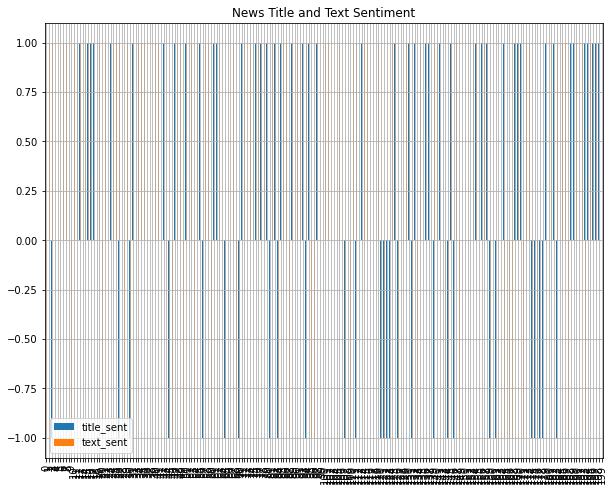

In [60]:
# Plot bar chart
combined_market_news_df.plot(
    y=["title_sent", "text_sent"],
    kind="bar",
    title="News Title and Text Sentiment",
    figsize=(10, 8),
    grid=True,
)

In [61]:
# Describe dataframe
combined_market_news_df.describe()

,title_compound,title_pos,title_neu,title_neg,title_sent,text_compound,text_pos,text_neu,text_neg,text_sent
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,0.019690,0.084640,0.849770,0.065590,0.095000,0.149320,0.080405,0.875735,0.043865,0.270000
std,0.332628,0.122476,0.167556,0.122619,0.720117,0.470749,0.076644,0.085408,0.063214,0.866518
min,-0.904200,0.000000,0.395000,0.000000,-1.000000,-0.908100,0.000000,0.627000,0.000000,-1.000000
25%,0.000000,0.000000,0.751750,0.000000,0.000000,-0.089900,0.000000,0.823250,0.000000,-1.000000
50%,0.000000,0.000000,0.875000,0.000000,0.000000,0.140550,0.066000,0.879000,0.000000,1.000000
75%,0.202300,0.176250,1.000000,0.112000,1.000000,0.546075,0.128250,0.936000,0.068250,1.000000
max,0.750600,0.457000,1.000000,0.484000,1.000000,0.915300,0.269000,1.000000,0.289000,1.000000
